# Прогнозирование стоимости автомобиля по характеристикам


# Подготовительные операции

In [1]:
# установим недостающие библиотеки
!pip install -q --upgrade pip
!pip install -q tensorflow==2.3
!pip install -q albumentations
!pip install -q pandas-profiling

In [2]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler, PowerTransformer

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

from scipy import stats

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [3]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [4]:
# фиксируем RANDOM_SEED
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
!pip freeze > requirements.txt

# Подгружаем данные

In [6]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [7]:
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [8]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# Заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# Округлим
predicts = (predicts // 1000) * 1000

# Оценим точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

С помощью пакета Pandas Profiling легко осуществляем EDA анализ датасета и получаем все нужные нам характеристики в одном месте.

In [9]:
#ProfileReport(train, title='Pandas Profiling Report').to_widgets()

Итого мы видим:
* В признаках **descriprion, enginePower, model_info, name, vehicleConfiguration, Владение** очень большое количество уникальных значений.
* В парах признаков **(productionDate, modelDate), (numberOfDoors, bodyType)** присутствует высокая корреляция.
* В признаке **Владение** пропущено 64.7% значений.
* В признаке **Руль** почти нет машин с правым расположением руля, поэтому просто уберем этот признак.

Приступим к обработке признаков.

# Предобработка признаков

In [10]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [11]:
# Убираем не нужные для модели признаки и по одному из попарно коррелированных 
# modelDate (оставляем productionDate как более важный) и numberOfDoors (оставляем bodyType как более важный)
data.drop(['name', 'Руль', 'vehicleConfiguration','modelDate', 'numberOfDoors'], axis = 1, inplace=True)

In [12]:
# ################### Feature Engineering ####################################################
# engineDisplacement - преобразование  в числ.
data.engineDisplacement = data.engineDisplacement.apply(lambda x: x.split()[0] if x!='undefined LTR' else '1.6').astype(float)
# enginePower - преобразование  в числ.
data.enginePower = data.enginePower.apply(lambda x: x.split()[0]).astype(int)
# Владение - преобразование  в числ.
data['Владение'] = data['Владение'].apply(lambda x: x.split() if not pd.isna(x) else x)
data['Владение'] = data['Владение'].apply(lambda x: x if not isinstance(x, list) else (12*int(x[0]) + int(x[3])) 
                                                      if len(x) > 3 else 12*int(x[0])
                                                      if x[1][0] == 'г' else int(x[0])
                                         )
data['Владение'] = data['Владение'].fillna(round(data.groupby('brand')['Владение'].transform('median')))
data['Владение'] = data['Владение'].astype('int32')
# hpToLtr - новый признак
data['hpToLtr'] = data['enginePower'] / data['engineDisplacement']
# kmPerYear - новый признак
data['kmPerYear'] = data['mileage'] / (2021-data['productionDate'])
# engineDisplacement - преобразование орбратно в категор.
data.engineDisplacement = data.engineDisplacement.apply(lambda x: 'small' if x<2 else 'middle' if 2<=x<3.5 else 'big' )

In [13]:
#ProfileReport(data, title='Pandas Profiling Report').to_widgets()

In [14]:
# Используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'engineDisplacement',]
# Используем все числовые признаки
numerical_features = ['enginePower', 'mileage', 'productionDate', 'Владение', 'hpToLtr', 'kmPerYear',]

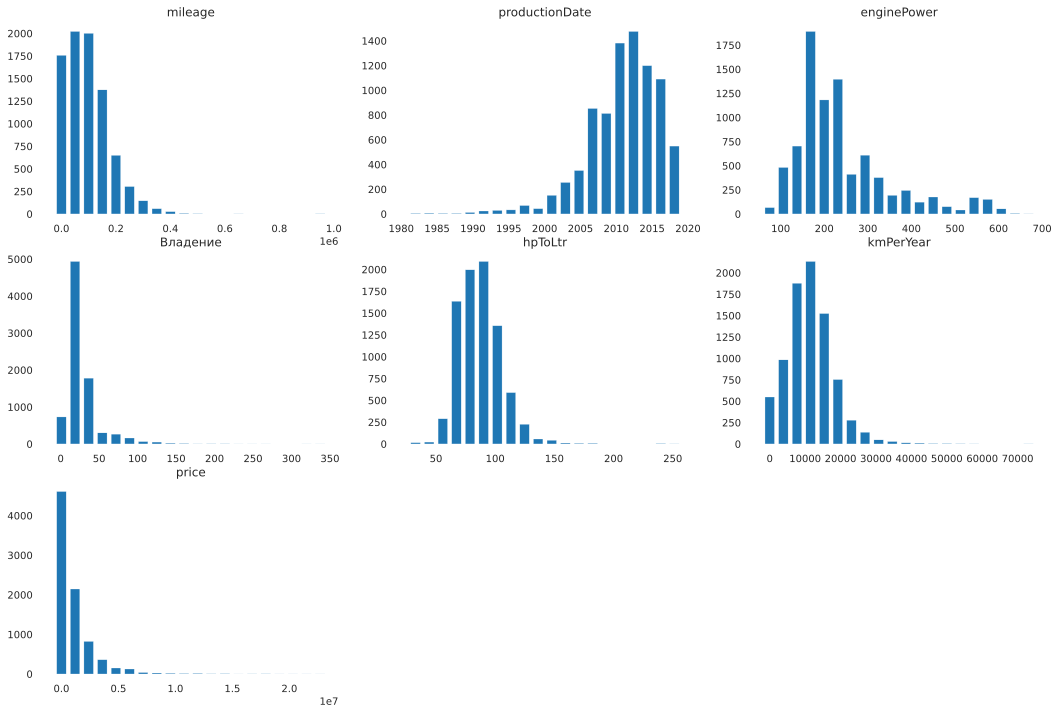

In [15]:
# Посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()
visualize_distributions({
    'mileage': data['mileage'],
    'productionDate': data['productionDate'],
    'enginePower': data['enginePower'],
    'Владение': data['Владение'],
    'hpToLtr': data['hpToLtr'],
    'kmPerYear': data['kmPerYear'],
    'price': data['price'],
 
})

In [16]:
# ################### Numerical Features ############################################################## 
# Приближаем распределение к более нормальному
# numerical features
#for column in numerical_features:
#    data[column] = PowerTransformer(method='yeo-johnson').fit_transform(data[[column]])
#data['mileage'] = PowerTransformer(method='box-cox', standardize=False).fit_transform(data[['mileage']])
data['mileage'] = QuantileTransformer(n_quantiles=1000, output_distribution='normal').fit_transform(data[['mileage']])
#data['productionDate'] = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(data[['productionDate']])
data['productionDate'] = QuantileTransformer(n_quantiles=1000, output_distribution='normal').fit_transform(data[['productionDate']])
#data['enginePower'] = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(data[['enginePower']])
data['enginePower'] = QuantileTransformer(n_quantiles=1000, output_distribution='normal').fit_transform(data[['enginePower']])
#data['Владение'] = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(data[['Владение']])
data['Владение'] = QuantileTransformer(n_quantiles=1000, output_distribution='normal').fit_transform(data[['Владение']])
#data['hpToLtr'] = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(data[['hpToLtr']])
data['hpToLtr'] = QuantileTransformer(n_quantiles=1000, output_distribution='normal').fit_transform(data[['hpToLtr']])
#data['kmPerYear'] = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(data[['kmPerYear']])
data['kmPerYear'] = QuantileTransformer(n_quantiles=1000, output_distribution='normal').fit_transform(data[['kmPerYear']])
# target
data['price'] = data['price'].apply(lambda x: np.log1p(x))
# Нормализуем данные
# numerical features
for column in numerical_features:
    data[column] = MinMaxScaler().fit_transform(data[[column]])
#    data[column] = RobustScaler().fit_transform(data[[column]])
#    data[column] = QuantileTransformer().fit_transform(data[[column]])

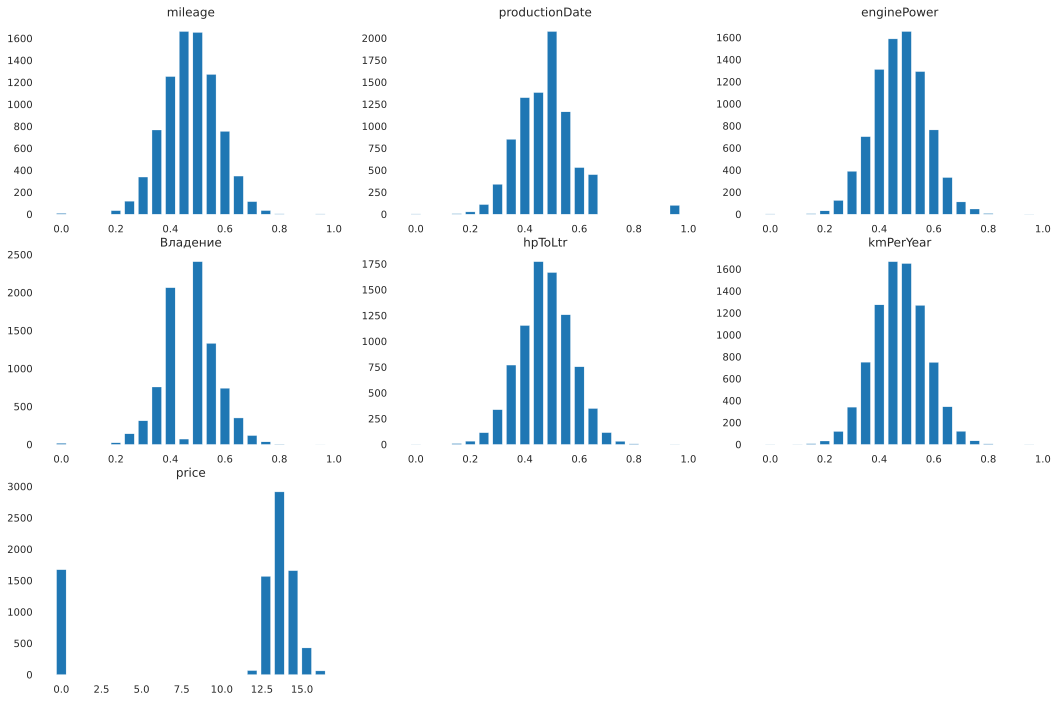

In [17]:
# Посмотрим, как теперь выглядят распределения числовых признаков
visualize_distributions({
    'mileage': data['mileage'],
    'productionDate': data['productionDate'],
    'enginePower': data['enginePower'],
    'Владение': data['Владение'],
    'hpToLtr': data['hpToLtr'],
    'kmPerYear': data['kmPerYear'],
    'price': data['price'],
 })

In [18]:
# ################### Categorical Features ############################################################## 
# Label Encoding
for column in categorical_features:
    data[column] = data[column].astype('category').cat.codes       
# One-Hot Encoding
data = pd.get_dummies(data, columns=categorical_features, dummy_na=True)

# Разделение данных на трейн и тест

In [19]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample', 'description', 'sell_id'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'description', 'sell_id'], axis=1)

y = train_data.price.values
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

# Model 2: CatBoostRegressor

### Model

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [21]:
model = CatBoostRegressor(iterations = 20000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=400,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.009897
0:	learn: 0.0423358	test: 0.0423924	best: 0.0423924 (0)	total: 66.1ms	remaining: 22m 1s
400:	learn: 0.0111885	test: 0.0109983	best: 0.0109983 (400)	total: 2.29s	remaining: 1m 51s
800:	learn: 0.0099835	test: 0.0100309	best: 0.0100309 (800)	total: 4.62s	remaining: 1m 50s
1200:	learn: 0.0093888	test: 0.0096098	best: 0.0096098 (1200)	total: 6.85s	remaining: 1m 47s
1600:	learn: 0.0088113	test: 0.0092117	best: 0.0092117 (1600)	total: 9.09s	remaining: 1m 44s
2000:	learn: 0.0084021	test: 0.0089367	best: 0.0089367 (2000)	total: 11.3s	remaining: 1m 42s
2400:	learn: 0.0080760	test: 0.0087346	best: 0.0087346 (2400)	total: 12.7s	remaining: 1m 33s
2800:	learn: 0.0078186	test: 0.0085915	best: 0.0085914 (2798)	total: 14s	remaining: 1m 26s
3200:	learn: 0.0075950	test: 0.0084743	best: 0.0084743 (3200)	total: 15.5s	remaining: 1m 21s
3600:	learn: 0.0073935	test: 0.0083798	best: 0.0083798 (3600)	total: 16.8s	remaining: 1m 16s
4000:	learn: 0.0072110	test: 0.0083094	best: 0.0083

In [22]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 0.79%


### Submission

In [23]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

## Построение обычной нейронной сети

### Model

In [24]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               99840     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 231,425
Trainable params: 231,425
Non-trainable params: 0
_________________________________________________________________


In [26]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [27]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor='val_MAPE', verbose=0  , mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=50,)
callbacks_list = [
    checkpoint, 
#    earlystop
]

### Fit

In [28]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

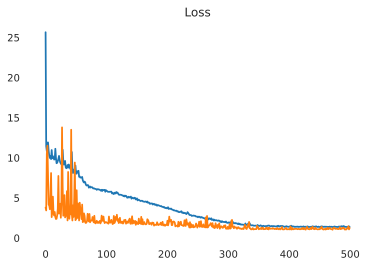

In [29]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [30]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [31]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 1.04%


In [32]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Промежуточные итоги по Model 3:

- Распределение пока не близко к нормальному.

- Числовые признаки из строковых данных извлечены.
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

- Размерность по возможности сокращена.
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Blend

In [33]:
blend_predict = (test_predict_catboost + test_predict_nn1[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 0.83%


In [34]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn1[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission['price'] = sample_submission['price'].apply(lambda x: np.expm1(x))
sample_submission.to_csv('blend_submission.csv', index=False)

In [35]:
sample_submission['price']

0       5.429111e+05
1       2.648523e+06
2       6.450159e+05
3       5.101597e+05
4       2.978229e+06
            ...     
1666    9.827070e+05
1667    2.601274e+06
1668    1.546146e+06
1669    1.203301e+06
1670    1.169113e+06
Name: price, Length: 1671, dtype: float64